In [1]:
import csv
import datetime
import matplotlib.pylab as plt
import json
import pandas as pd

dic_key_doc_reports = 'doc_reports'
dic_key_face_reports = 'face_reports'
doc_factor_list=['visual_authenticity_result','image_integrity_result','face_detection_result','image_quality_result','supported_document_result','conclusive_document_quality_result','colour_picture_result','data_validation_result','data_consistency_result','data_comparison_result','police_record_result','compromised_document_result']
face_factor_list=['face_comparison_result','facial_image_integrity_result','visual_authenticity_result']

def get_consider_rate_factor_consider_attempt(factor):
    attempts_dic=return_attempts_dic()
    consider_rate_factor_consider_attempt={}
    for attempt in attempts_dic:
        doc_report_result=attempts_dic[attempt][dic_key_doc_reports]['result']
        face_report_result=attempts_dic[attempt][dic_key_face_reports]['result']
        attempt_date=datetime.datetime.strptime(attempts_dic[attempt][dic_key_doc_reports]['created_at'], '%Y-%m-%d %H:%M:%S').date()
        if factor in doc_factor_list:
            factor_result=attempts_dic[attempt][dic_key_doc_reports][factor]
        elif factor in face_factor_list:
            factor_result=attempts_dic[attempt][dic_key_face_reports][factor]
        if doc_report_result == 'consider' or face_report_result == 'consider':
            if not attempt_date in consider_rate_factor_consider_attempt:
                if factor_result=='consider':
                    consider_rate_factor_consider_attempt[attempt_date]={'consider_count':1,'total_count':1}
                else:
                    consider_rate_factor_consider_attempt[attempt_date]={'consider_count':0,'total_count':1}
            else:
                if factor_result=='consider':
                    consider_rate_factor_consider_attempt[attempt_date]['consider_count']+=1
                consider_rate_factor_consider_attempt[attempt_date]['total_count']+=1
    
    for date in consider_rate_factor_consider_attempt.keys():
        consider_rate_factor_consider_attempt[date]=consider_rate_factor_consider_attempt[date]['consider_count']/consider_rate_factor_consider_attempt[date]['total_count']
    return consider_rate_factor_consider_attempt

def get_property_distribution(factor,property_type):
    attempts_dic=return_attempts_dic()
    property_distribution={}
    for attempt in attempts_dic:
        if factor in doc_factor_list:
            factor_result=attempts_dic[attempt][dic_key_doc_reports][factor]
        elif factor in face_factor_list:
            factor_result=attempts_dic[attempt][dic_key_face_reports][factor]
        if factor_result=='consider':
            property_dic=json.loads(attempts_dic[attempt][dic_key_doc_reports]['properties'].replace("'",'"').replace('None',"NaN"))
            attempt_date=datetime.datetime.strptime(attempts_dic[attempt][dic_key_doc_reports]['created_at'], '%Y-%m-%d %H:%M:%S').date()
            if property_type in property_dic:
                property_value=property_dic[property_type]
                if not attempt_date in property_distribution:
                    property_distribution[attempt_date]={}
                    property_distribution[attempt_date][property_value]=1
                else:
                    if not property_value in property_distribution[attempt_date]:
                        property_distribution[attempt_date][property_value]=1
                    else:
                        property_distribution[attempt_date][property_value]+=1
    return property_distribution
    
def get_number_attempt_per_user():
    number_attempt_per_user={}
    attempts_dic=return_attempts_dic()
    for attempt in attempts_dic:
        user_id=attempts_dic[attempt][dic_key_doc_reports]['user_id']
        if not user_id in number_attempt_per_user:
            number_attempt_per_user[user_id] = 1
        else:
            number_attempt_per_user[user_id]+=1
    return number_attempt_per_user

def get_user_count_by_attempt_count():
    user_count_by_attempt_count={}
    number_attempt_per_user=get_number_attempt_per_user()
    for user in number_attempt_per_user:
        if not number_attempt_per_user[user] in user_count_by_attempt_count:
            user_count_by_attempt_count[number_attempt_per_user[user]]=1
        else:
            user_count_by_attempt_count[number_attempt_per_user[user]]+=1
    return user_count_by_attempt_count

def get_user_attempted_once_and_fail():
    user_result_date = get_user_result_date()
    user_set=set()
    for user in user_result_date:
        if user_result_date[user]['result']=='consider':
            user_set.add(user)
    return user_set

def get_user_result_date():
    attempts_dic=return_attempts_dic()
    user_result_date={}
    for attempt in attempts_dic:
        attempt_date=datetime.datetime.strptime(attempts_dic[attempt][dic_key_doc_reports]['created_at'], '%Y-%m-%d %H:%M:%S').date()
        user_id=attempts_dic[attempt][dic_key_doc_reports]['user_id']
        doc_report_result=attempts_dic[attempt][dic_key_doc_reports]['result']
        face_report_result=attempts_dic[attempt][dic_key_face_reports]['result']
        if doc_report_result == 'clear' and face_report_result == 'clear':
            result = 'clear'
        else:
            result = 'consider'
        if not user_id in user_result_date:
            user_result_date[user_id]={'date':attempt_date,'result':result}
        else:
            if result == 'clear' and attempt_date>user_result_date[user_id]['date']:
                user_result_date[user_id]['result']=result
                user_result_date[user_id]['date']=attempt_date
                
    return user_result_date

def get_daily_pass_rate():
    user_result_date=get_user_result_date()
    daily_pass_rate={}
    for user in user_result_date.keys():
        date=user_result_date[user]['date']
        result=user_result_date[user]['result']
        if not date in daily_pass_rate:
            if result == 'clear':
                daily_pass_rate[date]={'clear_count':1,'total_count':1}
            else:
                daily_pass_rate[date]={'clear_count':0,'total_count':1}
        else:
            if result == 'clear':
                daily_pass_rate[date]['clear_count']+=1
            daily_pass_rate[date]['total_count']+=1
    
    for date in daily_pass_rate.keys():
        daily_pass_rate[date]=daily_pass_rate[date]['clear_count']/daily_pass_rate[date]['total_count']
    return daily_pass_rate

def plot_dictionary(dictionary):
    lists = sorted(dictionary.items())
    x, y = zip(*lists)
    plt.plot(x, y)
    plt.show()

def plot_bar(dictionary):
    pd.DataFrame(dictionary).T.plot()
    plt.show()
    
def return_attempts_dic():
    attempts_dic={}
    file_doc_reports_sample=csv.DictReader(open('doc_reports_sample.csv', 'r'))
    file_face_reports_sample=csv.DictReader(open('face_reports_sample.csv', 'r'))
    for row in file_doc_reports_sample:
        attempts_dic[str(dict(row)['attempt_id'])]={}
        attempts_dic[str(dict(row)['attempt_id'])][dic_key_doc_reports]=dict(row)
    for row in file_face_reports_sample:
        attempts_dic[str(dict(row)['attempt_id'])][dic_key_face_reports]=dict(row)
    return attempts_dic

In [ ]:
return_attempts_dic()

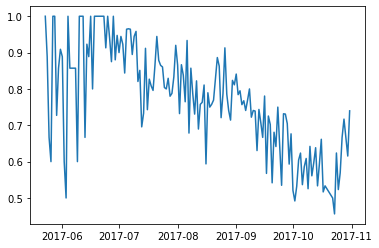

In [2]:
plot_dictionary(get_daily_pass_rate())

In [3]:
len(get_user_attempted_once_and_fail())

1622

In [4]:
get_user_count_by_attempt_count()

{1: 5816, 2: 32}

visual_authenticity_result


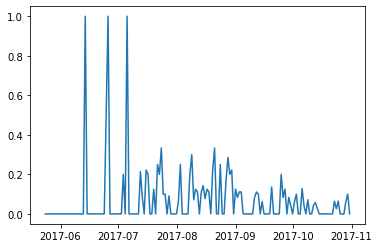

image_integrity_result


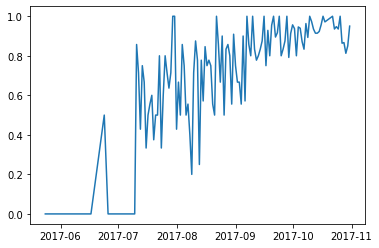

face_detection_result


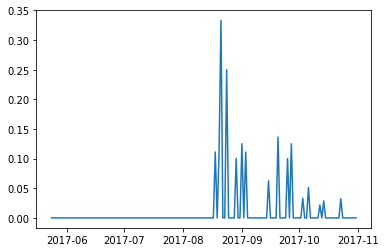

image_quality_result


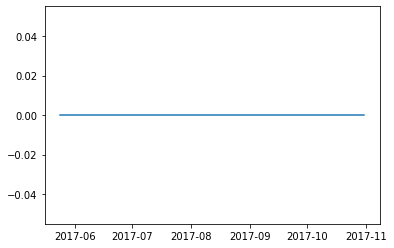

supported_document_result


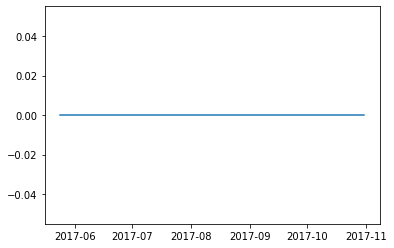

conclusive_document_quality_result


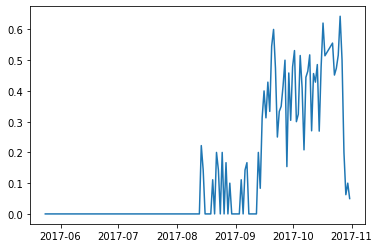

colour_picture_result


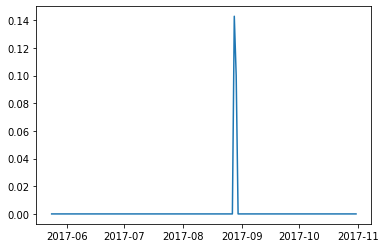

data_validation_result


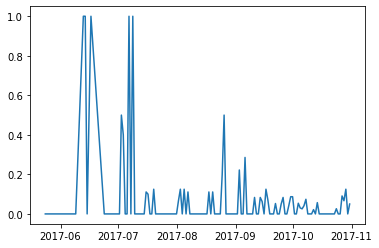

data_consistency_result


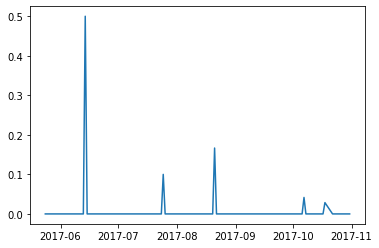

data_comparison_result


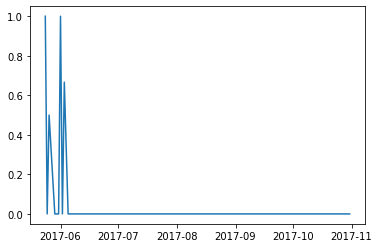

police_record_result


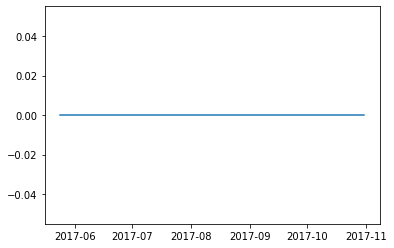

compromised_document_result


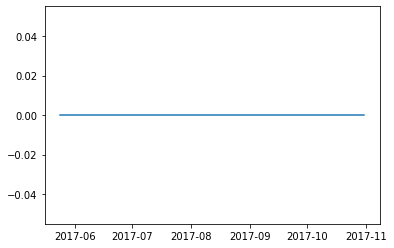

face_comparison_result


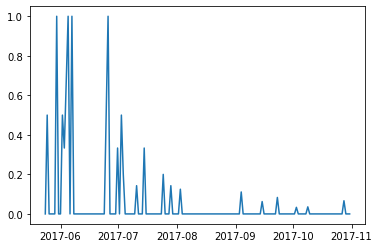

facial_image_integrity_result


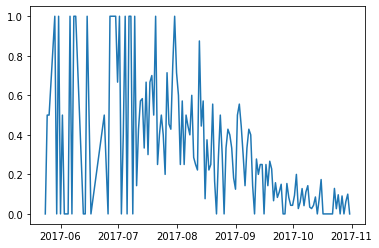

visual_authenticity_result


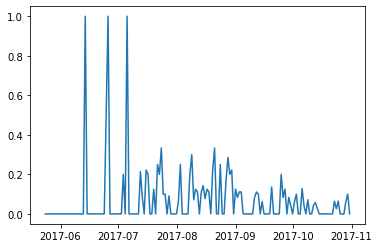

In [5]:
for factor in doc_factor_list + face_factor_list:
    print(factor)
    plot_dictionary(get_consider_rate_factor_consider_attempt(factor))

property = document_type


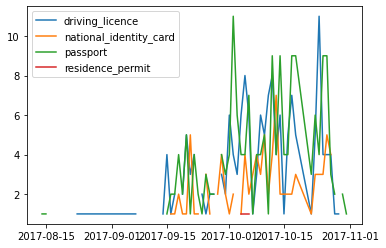

property = gender


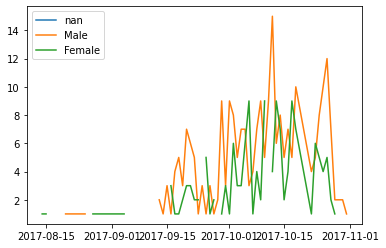

property = issuing_country


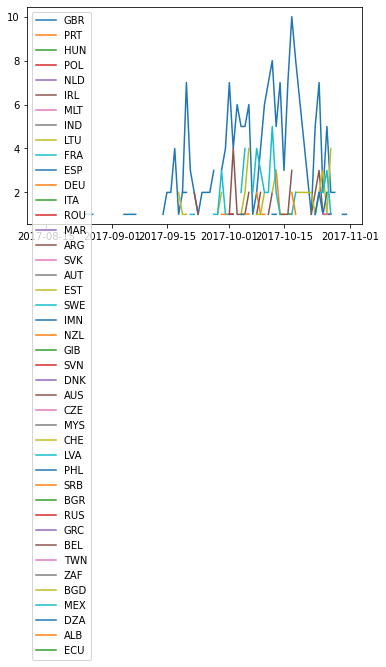

property = nationality


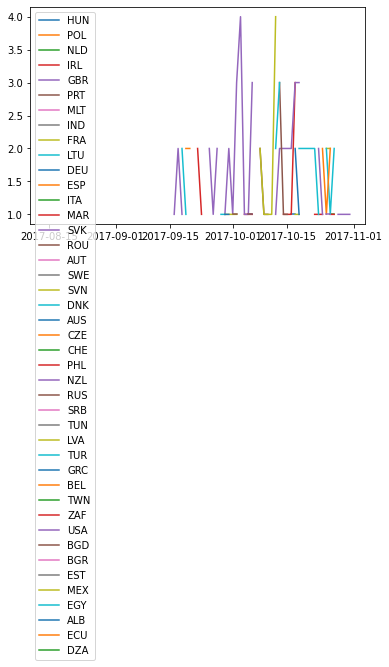

In [6]:
problematic_factor=['conclusive_document_quality_result']
property_list=['document_type','gender','issuing_country','nationality']

for factor in problematic_factor:
    for prpty in property_list:
        print(f'property = {prpty}')
        plot_bar(get_property_distribution(factor,prpty))